Accuracy (Decision Stump): 0.84


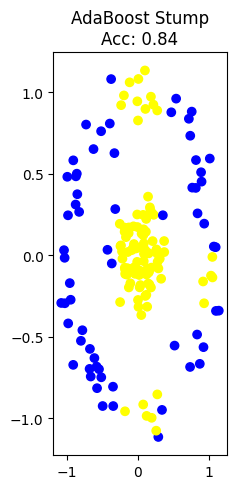

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

# Decision stump used as weak classifier
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions

class Adaboost(BaseEstimator, ClassifierMixin):
    def __init__(self, n_clf=5,eta=0.5):
        self.n_clf = n_clf
        self.eta = eta
        self.clfs = []
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        for _ in range(self.n_clf):
            clf, min_error = None, float('inf')
            clf = DecisionStump()
            # Greedy search to find the best threshold and feature for decision stump
            for feature_i in range(n_features):
                X_column = X[:, feature_i]
                thresholds = np.unique(X_column)
                for threshold in thresholds:
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1
                    error = sum(w[y != predictions])
                    if error > 0.5:
                        error = 1 - error
                        p = -1
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error

            # Calculate alpha
            EPS = 1e-10
            clf.alpha = self.eta * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # Update weights
            predictions = clf.predict(X)
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

    def score(self, X, y):
        """
        Calculate accuracy score for the given data.
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True): # Implement get_params method
        return {"n_clf": self.n_clf, "base_model": self.base_model, "eta": self.eta}

    def set_params(self, **parameters): # Implement set_params method
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def plot_decision_boundary(self, X, y):
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                          np.arange(y_min, y_max, 0.01))
      Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      plt.contourf(xx, yy, Z, alpha=0.6, cmap=colors.ListedColormap(['#FFAAAA', '#AAAAFF']))
      plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'red']))
      plt.xlabel('Feature 1')
      plt.ylabel('Feature 2')
      plt.title('Decision Boundary')

# Test the updated AdaBoost with multiple classifiers on the given dataset
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Generate dataset
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y[y == 0] = -1  # Adaboost assumes labels are -1 and 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Initialize AdaBoost with decision stump
ada_stump = Adaboost(n_clf=50)
ada_stump.fit(X_train, y_train)
stump_pred = ada_stump.predict(X_test)
stump_acc = accuracy_score(y_test, stump_pred)

# Print accuracy scores
print(f"Accuracy (Decision Stump): {stump_acc:.2f}")

# Predict and visualize decision boundaries
plt.figure(figsize=(10, 5))

# Decision Stump
plt.subplot(1, 5, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=stump_pred, cmap=colors.ListedColormap(["blue", "yellow"]))
plt.title(f"AdaBoost Stump\nAcc: {stump_acc:.2f}")

plt.tight_layout()
plt.show()

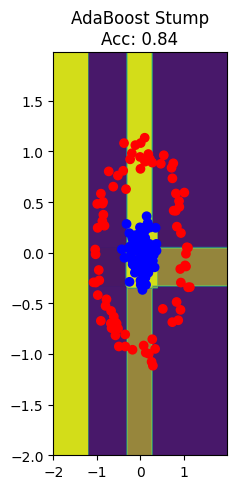

In [ ]:
# prompt: plots the decision boundaries at each iteration of the ensemble learning process.
# Define the plot range:
# Same as in plot_decision_boundary.
# Create a mesh grid:
# Same as in plot_decision_boundary.
# Iterate through classifiers:
# For each iteration t up to self.n_clf (number of classifiers):
# Calculate the weighted sum of predictions from the first t+1 classifiers.
# Z: Sum of weighted predictions, reshaped to match the shape of xx.
# plt.contourf: Plot filled contours for the decision boundary at this iteration with low alpha for transparency.
# Plot the data points

def plot_decision_boundary_ensemble(X, y, clf, ax, title, range_x=(-2, 2), range_y=(-2, 2)):
    h = .02  # step size in the mesh
    x_min, x_max = range_x
    y_min, y_max = range_y
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    for t in range(clf.n_clf):
        Z = np.sum([clf.clfs[i].alpha * clf.clfs[i].predict(np.c_[xx.ravel(), yy.ravel()]) for i in range(t+1)], axis=0)
        Z = np.sign(Z)
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.2)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(["red", "blue"]))
    ax.set_title(title)

# Plot the decision boundaries for each iteration
plt.figure(figsize=(10, 5))

# Decision Stump
plt.subplot(1, 5, 1)
plot_decision_boundary_ensemble(X_test, y_test, ada_stump, plt.gca(), f"AdaBoost Stump\nAcc: {stump_acc:.2f}")

plt.tight_layout()
plt.show()

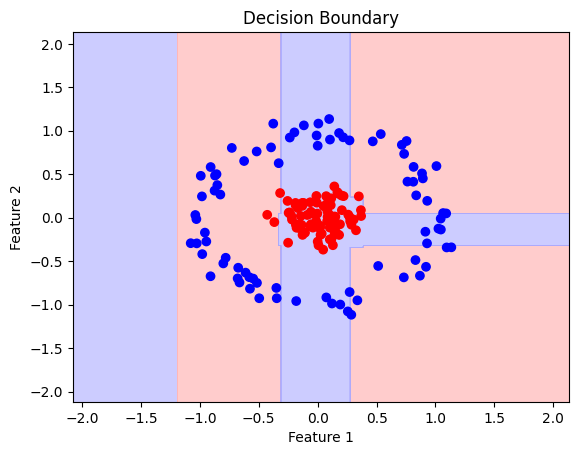

In [ ]:

plt.figure()
ada_stump.plot_decision_boundary(X_test, y_test)
plt.show()


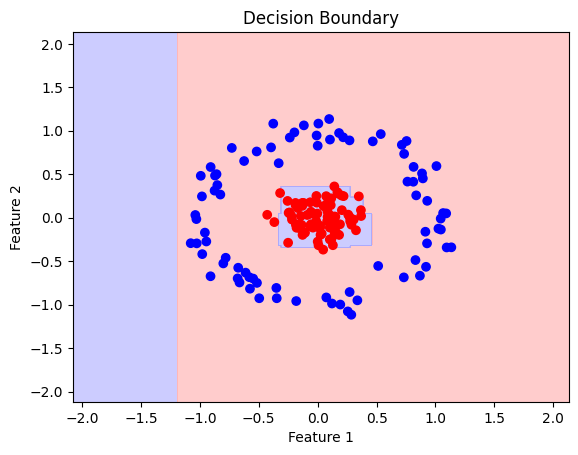

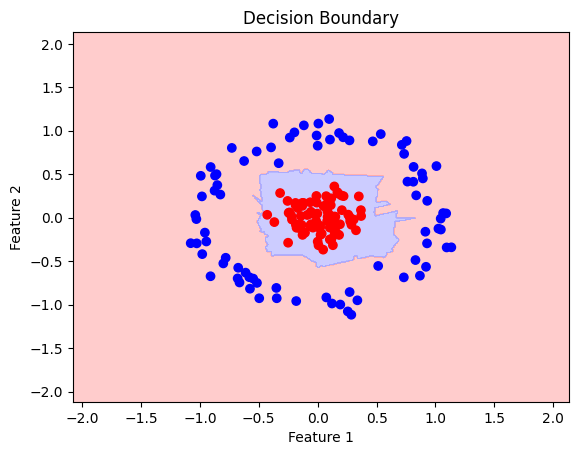

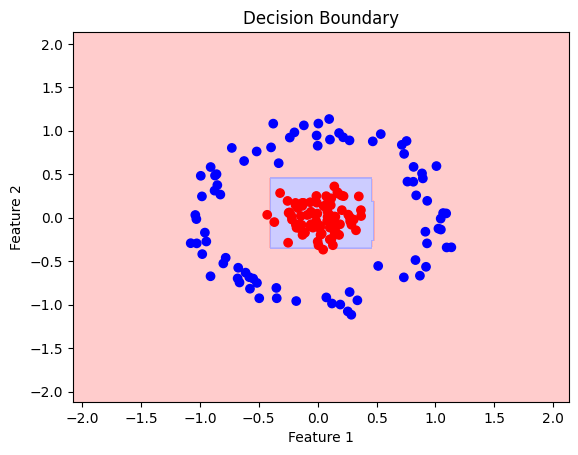

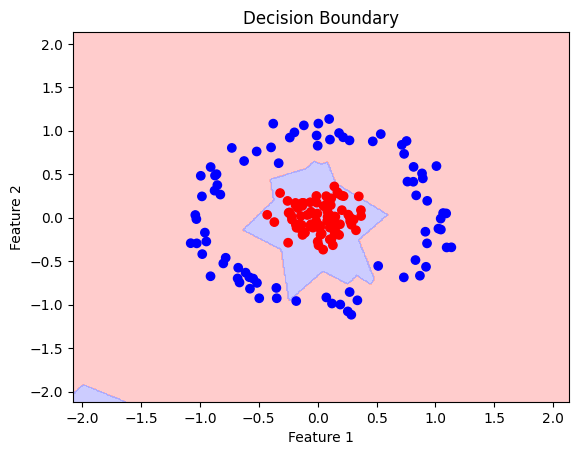

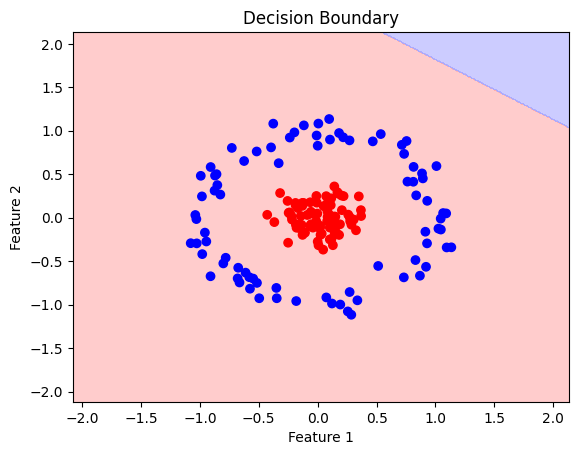

Accuracy (Decision Stump): 0.96
Accuracy (Logistic Regression): 1.00
Accuracy (Decision Tree): 0.99
Accuracy (Linear SVM): 0.99
Accuracy (LDA): 0.49


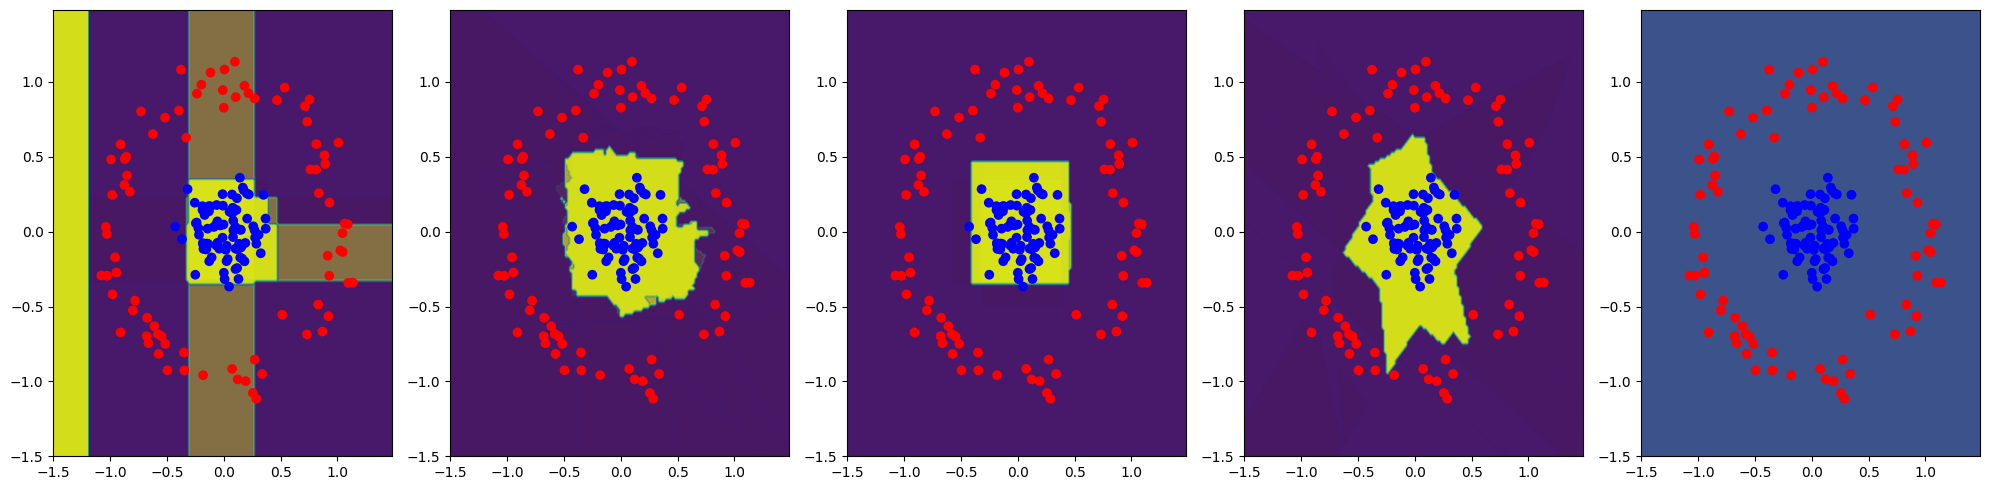

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

# Decision stump used as weak classifier
class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions

class Adaboost(BaseEstimator, ClassifierMixin):
    def __init__(self, n_clf=5, base_model='stump',eta=0.5):
        self.n_clf = n_clf
        self.base_model = base_model
        self.eta = eta
        self.clfs = []
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        for _ in range(self.n_clf):
            clf, min_error = None, float('inf')

            if self.base_model == 'stump':
                clf = DecisionStump()
                # Greedy search to find the best threshold and feature for decision stump
                for feature_i in range(n_features):
                    X_column = X[:, feature_i]
                    thresholds = np.unique(X_column)
                    for threshold in thresholds:
                        p = 1
                        predictions = np.ones(n_samples)
                        predictions[X_column < threshold] = -1
                        error = sum(w[y != predictions])
                        if error > 0.5:
                            error = 1 - error
                            p = -1
                        if error < min_error:
                            clf.polarity = p
                            clf.threshold = threshold
                            clf.feature_idx = feature_i
                            min_error = error
            else:
                # Fit different classifiers from scikit-learn
                if self.base_model == 'logreg':
                    clf = LogisticRegression()
                elif self.base_model == 'decision_tree':
                    clf = DecisionTreeClassifier(max_depth=3)
                elif self.base_model == 'svm':
                    clf = LinearSVC(dual=True)
                elif self.base_model == 'lda':
                    clf = LinearDiscriminantAnalysis()

                # Train the classifier with sample weights
                if self.base_model != 'lda':  # Check if the model is not LDA
                    clf.fit(X, y, sample_weight=w)
                else:
                    clf.fit(X, y)
                predictions = clf.predict(X)
                misclassified = w[y != predictions]
                error = sum(misclassified)

                if error < min_error:
                    min_error = error

            # Calculate alpha
            EPS = 1e-10
            clf.alpha = self.eta * np.log((1.0 - min_error + EPS) / (min_error + EPS))

            # Update weights
            predictions = clf.predict(X)
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

    def score(self, X, y):
        """
        Calculate accuracy score for the given data.
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True): # Implement get_params method
        return {"n_clf": self.n_clf, "base_model": self.base_model, "eta": self.eta}

    def set_params(self, **parameters): # Implement set_params method
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def plot_decision_boundary(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                            np.arange(y_min, y_max, 0.01))
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.6, cmap=colors.ListedColormap(['#FFAAAA', '#AAAAFF']))
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'red']))
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Decision Boundary')


# Test the updated AdaBoost with multiple classifiers on the given dataset
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Generate dataset
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y[y == 0] = -1  # Adaboost assumes labels are -1 and 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Initialize AdaBoost with decision stump
ada_stump = Adaboost(n_clf=50, base_model='stump',eta=0.4)
ada_stump.fit(X_train, y_train)
stump_pred = ada_stump.predict(X_test)
stump_acc = accuracy_score(y_test, stump_pred)
#also call the plot_decision_boundary
ada_stump.plot_decision_boundary(X_test, y_test)
plt.show()

# Initialize AdaBoost with Logistic Regression
ada_logreg = Adaboost(n_clf=200, base_model='logreg',eta=0.6)
ada_logreg.fit(X_train, y_train)
logreg_pred = ada_logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_pred)
ada_logreg.plot_decision_boundary(X_test, y_test)
plt.show()

# Initialize AdaBoost with Decision Tree
ada_tree = Adaboost(n_clf=50, base_model='decision_tree',eta=0.4)
ada_tree.fit(X_train, y_train)
tree_pred = ada_tree.predict(X_test)
tree_acc = accuracy_score(y_test, tree_pred)
ada_tree.plot_decision_boundary(X_test, y_test)
plt.show()

# Initialize AdaBoost with Linear SVM
ada_svm = Adaboost(n_clf=200, base_model='svm',eta=0.6)
ada_svm.fit(X_train, y_train)
svm_pred = ada_svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
ada_svm.plot_decision_boundary(X_test, y_test)
plt.show()

# Initialize AdaBoost with LDA
ada_lda = Adaboost(n_clf=200, base_model='lda',eta=0.4)
ada_lda.fit(X_train, y_train)
lda_pred = ada_lda.predict(X_test)
lda_acc = np.mean(y_test==lda_pred)
ada_lda.plot_decision_boundary(X_test, y_test)
plt.show()

# Print accuracy scores
print(f"Accuracy (Decision Stump): {stump_acc:.2f}")
print(f"Accuracy (Logistic Regression): {logreg_acc:.2f}")
print(f"Accuracy (Decision Tree): {tree_acc:.2f}")
print(f"Accuracy (Linear SVM): {svm_acc:.2f}")
print(f"Accuracy (LDA): {lda_acc:.2f}")

fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Increased figsize for better visualization

# Decision Stump
axes[0].scatter(X_test[:, 0], X_test[:, 1], c=stump_pred, cmap=colors.ListedColormap(["blue", "yellow"]))
axes[0].set_title(f"AdaBoost Stump\nAcc: {stump_acc:.2f}")
plot_decision_boundary_ensemble(X_test, y_test, ada_stump, axes[0], "", range_x=(-1.5, 1.5), range_y=(-1.5, 1.5))  # Call for decision boundaries

# Logistic Regression
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=logreg_pred, cmap=colors.ListedColormap(["blue", "yellow"]))
axes[1].set_title(f"AdaBoost LogReg\nAcc: {logreg_acc:.2f}")
plot_decision_boundary_ensemble(X_test, y_test, ada_logreg, axes[1], "", range_x=(-1.5, 1.5), range_y=(-1.5, 1.5))  # Call for decision boundaries

#likewise do the same thing for decision tree
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=tree_pred, cmap=colors.ListedColormap(["blue", "yellow"]))
axes[2].set_title(f"AdaBoost DecisionTree\nAcc: {tree_acc:.2f}")
plot_decision_boundary_ensemble(X_test, y_test, ada_tree, axes[2], "", range_x=(-1.5, 1.5), range_y=(-1.5, 1.5))  # Call for decision boundaries

axes[3].scatter(X_test[:, 0], X_test[:, 1], c=svm_pred, cmap=colors.ListedColormap(["blue", "yellow"]))
axes[3].set_title(f"AdaBoost SVM\nAcc: {svm_acc:.2f}")
plot_decision_boundary_ensemble(X_test, y_test, ada_svm, axes[3], "", range_x=(-1.5, 1.5), range_y=(-1.5, 1.5))

axes[4].scatter(X_test[:, 0], X_test[:, 1], c=lda_pred, cmap=colors.ListedColormap(["blue", "yellow"]))
axes[4].set_title(f"AdaBoost LDA\nAcc: {lda_acc:.2f}")
plot_decision_boundary_ensemble(X_test, y_test, ada_lda, axes[4], "", range_x=(-1.5, 1.5), range_y=(-1.5, 1.5))

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Change the base_model to 'decision_tree' instead of DecisionTreeClassifier instance
grid_search = GridSearchCV(
    estimator=Adaboost(base_model='lda'),  # Changed this line
    param_grid={
        'eta': [0.4, 0.5, 0.6],
        'n_clf': [200, 250, 500, 1000]
    },
    cv=5,
    refit=False,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
print('Best Params:' + repr(grid_search.best_params_))
print('Best Score: %.3f' % grid_search.best_score_)

Best Params:{'eta': 0.4, 'n_clf': 200}
Best Score: 0.663


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Change the base_model to 'decision_tree' instead of DecisionTreeClassifier instance
grid_search = GridSearchCV(
    estimator=Adaboost(base_model='svm'),  # Changed this line
    param_grid={
        'eta': [0.4, 0.5, 0.6],
        'n_clf': [200, 250, 500, 1000]
    },
    cv=5,
    refit=False,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
print('Best Params:' + repr(grid_search.best_params_))
print('Best Score: %.3f' % grid_search.best_score_)

Best Params:{'eta': 0.6, 'n_clf': 200}
Best Score: 0.773


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Change the base_model to 'decision_tree' instead of DecisionTreeClassifier instance
grid_search = GridSearchCV(
    estimator=Adaboost(base_model='logreg'),  # Changed this line
    param_grid={
        'eta': [0.4, 0.5, 0.6],
        'n_clf': [200, 250, 500, 1000]
    },
    cv=5,
    refit=False,
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
print('Best Params:' + repr(grid_search.best_params_))
print('Best Score: %.3f' % grid_search.best_score_)

Best Params:{'eta': 0.6, 'n_clf': 200}
Best Score: 1.000
